# Tarea 2 : Clasificación y búsqueda por similitud de sketches usando redes convolucionales

# CC6204 Deep Learning, Universidad de Chile <br/> Hoja de respuestas 

## Nombre: Martín Cornejo Saavedra
Fecha para completar la tarea: 17 de junio de 2018

In [0]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

from skimage.draw import line as drawLine

import pdb
import random
import os
import json

In [11]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Construcción del conjunto de datos

In [0]:
raw_categories = !gsutil ls -r "gs://quickdraw_dataset/full/simplified/*"

max_num_categories = 5
train_samples_per_cat = 100
test_samples_per_cat = 10

### Elegimos 100 categorias al azar y las descargamos

In [0]:
for idx, raw_cat in enumerate(raw_categories):
  raw_categories[idx] = raw_cat.replace(" ", "\ ")   # para que bash reconozca el espacio en la descarga

random_categories = []

while True:
  rand_cat = random.randint(0, len(raw_categories)-1)
  if rand_cat not in random_categories:
    random_categories.append(rand_cat)
  if len(random_categories) is max_num_categories:
    break

In [14]:
!mkdir quick_draw_data
os.chdir("/content/quick_draw_data")

mkdir: cannot create directory ‘quick_draw_data’: File exists


In [0]:
str_random_cat = []

os.system("mkdir train")
os.system("mkdir test")

for category in random_categories:
  aux = raw_categories[category].replace("gs://quickdraw_dataset/full/simplified/", "")
  aux = aux.replace(".ndjson", "")
  str_random_cat.append(aux)
  os.system("mkdir train/" + aux)
  os.system("mkdir test/" + aux)

In [16]:
for idx, category in enumerate(random_categories):
  os.system("gsutil cp " + raw_categories[category] + " .")
  print("La categoria " + str(idx+1) + " copiada es " + raw_categories[category])

La categoria 1 copiada es gs://quickdraw_dataset/full/simplified/screwdriver.ndjson
La categoria 2 copiada es gs://quickdraw_dataset/full/simplified/cooler.ndjson
La categoria 3 copiada es gs://quickdraw_dataset/full/simplified/oven.ndjson
La categoria 4 copiada es gs://quickdraw_dataset/full/simplified/kangaroo.ndjson
La categoria 5 copiada es gs://quickdraw_dataset/full/simplified/broccoli.ndjson
La categoria 6 copiada es gs://quickdraw_dataset/full/simplified/shorts.ndjson
La categoria 7 copiada es gs://quickdraw_dataset/full/simplified/star.ndjson
La categoria 8 copiada es gs://quickdraw_dataset/full/simplified/bracelet.ndjson
La categoria 9 copiada es gs://quickdraw_dataset/full/simplified/bat.ndjson
La categoria 10 copiada es gs://quickdraw_dataset/full/simplified/eraser.ndjson
La categoria 11 copiada es gs://quickdraw_dataset/full/simplified/jacket.ndjson
La categoria 12 copiada es gs://quickdraw_dataset/full/simplified/grapes.ndjson
La categoria 13 copiada es gs://quickdraw_dat

In [17]:
categories = !ls
print(len(categories))

for cat in str_random_cat:
  if (cat + ".ndjson").replace("\ ", " ") not in categories:
    print("falta " + cat)

54


### Se convierte la data en formato json a bitmaps de 128x128 y se guardan en formato .txt

In [0]:
def parse_line(ndjson_line):
  """Parse an ndjson line and return ink (as np array) and classname."""
  sample = json.loads(ndjson_line)
  class_name = sample["word"]
  if not class_name:
    print ("Empty classname")
    return None, None
  inkarray = sample["drawing"]

  div_scale = 2
  
  for idx, stroke in enumerate(inkarray):
    if len(stroke[0]) != len(stroke[1]):
      print("Inconsistent number of x and y coordinates.")
      return None, None
    
    for idy, x_coord in enumerate(stroke[0]):
      inkarray[idx][0][idy] /= div_scale
      inkarray[idx][1][idy] /= div_scale
  
  return inkarray, class_name

def convert_data(trainingdata_dir,
                 observations_per_class,
                 output_folder,
                 offset=0):
  file_handles = []
  # Open all input files.
  for filename in sorted(tf.gfile.ListDirectory(trainingdata_dir)):
    if not filename.endswith(".ndjson"):
      #print("Skipping", filename)
      continue
    file_handles.append(
        tf.gfile.GFile(os.path.join(trainingdata_dir, filename), "r"))
    if offset:  # Fast forward all files to skip the offset.
      count = 0
      for _ in file_handles[-1]:
        count += 1
        if count == offset:
          break

    
  reading_order = list(range(len(file_handles)))
          
  class_names = []  
    
  for idx in reading_order:
    for pictureNum in range(observations_per_class):
      line = file_handles[idx].readline()
      ink = None
      
      while ink is None:
        ink, class_name = parse_line(line)
        if ink is None:
          print ("Couldn't parse ink from '" + line + "'.")

      drawing = np.zeros((128, 128), dtype=np.uint8)
      
      if class_name not in class_names:
        class_names.append(class_name)      
        os.system("mkdir " + output_folder + str(idx))

      for linea in ink:
        for idy in range(len(linea[0])-1):
          rr, cc = drawLine(linea[1][idy], linea[0][idy], linea[1][idy+1], linea[0][idy+1])
          drawing[rr, cc] = 1

      np.savetxt(output_folder + str(idx) + "/" + str(pictureNum) + ".txt", drawing, fmt="%d", delimiter=" ")

In [0]:
convert_data(".",
             train_samples_per_cat,
             "train/")    

convert_data(".",
             test_samples_per_cat,
             "test/",
             train_samples_per_cat)    

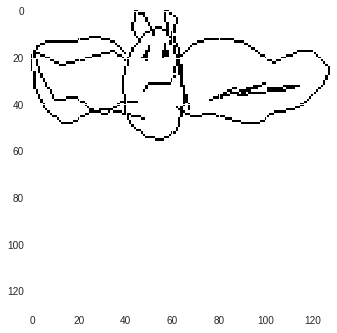

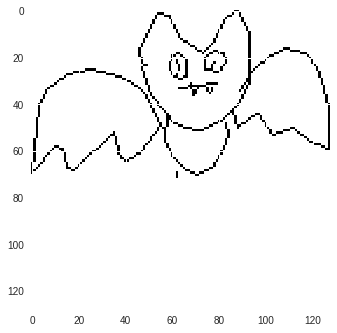

In [20]:
test_imagen = np.loadtxt("test/2/9.txt")
plt.imshow(test_imagen)
plt.show()

train_imagen = np.loadtxt("train/2/49.txt")
plt.imshow(train_imagen)
plt.show()

In [21]:
!ls test/4

0.txt	14.txt	19.txt	23.txt	28.txt	32.txt	37.txt	41.txt	46.txt	5.txt
10.txt	15.txt	1.txt	24.txt	29.txt	33.txt	38.txt	42.txt	47.txt	6.txt
11.txt	16.txt	20.txt	25.txt	2.txt	34.txt	39.txt	43.txt	48.txt	7.txt
12.txt	17.txt	21.txt	26.txt	30.txt	35.txt	3.txt	44.txt	49.txt	8.txt
13.txt	18.txt	22.txt	27.txt	31.txt	36.txt	40.txt	45.txt	4.txt	9.txt


## Construcción y entrenamiento de la skNet

### Construcción del grafo

In [0]:
def deepnn(x, training=False):
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 128, 128, 1])       

  conv1_1 = tf.layers.conv2d(
    inputs=x_image,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv1_1_n = tf.contrib.layers.batch_norm(conv1_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv1_2 = tf.layers.conv2d(
    inputs=conv1_1_n,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv1_2_n = tf.contrib.layers.batch_norm(conv1_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)

  pool1 = tf.layers.max_pooling2d(inputs=conv1_2_n, pool_size=[3, 3], strides=2)
  
  conv2_1 = tf.layers.conv2d(
    inputs=pool1,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv2_1_n = tf.contrib.layers.batch_norm(conv2_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv2_2 = tf.layers.conv2d(
    inputs=conv2_1_n,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv2_2_n = tf.contrib.layers.batch_norm(conv2_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)

  pool2 = tf.layers.max_pooling2d(inputs=conv2_2_n, pool_size=[3, 3], strides=2)
  
  conv3_1 = tf.layers.conv2d(
    inputs=pool2,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv3_1_n = tf.contrib.layers.batch_norm(conv3_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv3_2 = tf.layers.conv2d(
    inputs=conv3_1_n,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv3_2_n = tf.contrib.layers.batch_norm(conv3_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)

  pool3 = tf.layers.max_pooling2d(inputs=conv3_2_n, pool_size=[3, 3], strides=2)
  
  conv4_1 = tf.layers.conv2d(
    inputs=pool3,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv4_1_n = tf.contrib.layers.batch_norm(conv4_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv4_2 = tf.layers.conv2d(
    inputs=conv4_1_n,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv4_2_n = tf.contrib.layers.batch_norm(conv4_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)

  pool4 = tf.layers.max_pooling2d(inputs=conv4_2_n, pool_size=[3, 3], strides=2)

  # Dense layer
  
  pool2_flat = tf.reshape(pool4, [-1, 7*7*256])
  dense_l = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  
  # Logits Layer
  
  logits = tf.layers.dense(inputs=dense_l, units=max_num_categories)
  
  return logits

### Se crea una clase para extraer datos de entrenamiento

In [0]:
class QuickDataset():
  def __init__(self, data_path, samples_per_cat):    
    self.x = []
    self.y = []
    
    for idx in range(max_num_categories):
      folder = "/" + str(idx)
  
      for idy in range(samples_per_cat):
           
        train_input = np.loadtxt(data_path + folder + "/" + str(idy) + ".txt")
        self.x.append(np.resize(train_input, (1, 16384))[0])
        #self.y.append(np.eye(max_num_categories)[np.array(idx)])
        self.y.append(idx)
  
  def paquetes(self, B):
       
    n_iters = int(len(self.x)/B)
    arr_paquetes = []
   
    for index in range(n_iters):
      arr_paquetes.append(self.elige_batch(self.x,self.y,B))
              
    self.arr_paquetes = arr_paquetes
      
    return self.arr_paquetes
  
  def elige_batch(self, X, Y, b):
    N = len(self.x)
    x_lista = []
    y_lista = []
  
    for _ in range(b):
      i = np.random.randint(N)
      x_lista.append(X[i:i+1])
      y_lista.append(Y[i:i+1])
  
    x = np.concatenate(x_lista, axis=0)
    y = np.concatenate(y_lista, axis=0)
  
    return x, y
  
train_dataset = QuickDataset("train", train_samples_per_cat)
test_dataset = QuickDataset("test", test_samples_per_cat)

### Entrenamiento de skNet

In [32]:
x = tf.placeholder(tf.float16, shape=(None, 128*128))
y_ = tf.placeholder(tf.int64, shape=(None))
y_conv = deepnn(x, True)
    
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_,
                                                          logits=y_conv)
cross_entropy = tf.reduce_mean(cross_entropy)

# hiperparámetros de entrenamiento
batch_size = 10
n_epochs = 1
learning_rate= 0.001

train_step = tf.train.GradientDescentOptimizer(learning_rate)
train_step = train_step.minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), y_)
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

loss_array = []
train_acc = []
val_acc = []
test_acc = []   
cnf_matrix = []


with tf.Session() as sess:
  init = tf.global_variables_initializer()
  init.run()    
  for idz in range(n_epochs):
    batches = train_dataset.paquetes(batch_size)
    
    for idx, batch in enumerate(batches): 
      #pdb.set_trace()
      if idx % 5 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1]})
        print('step %d, training set accuracy %g' % (idx, train_accuracy))      
      
      sess.run(train_step, feed_dict={x: batch[0], y_: batch[1]})
    
  test_batches = test_dataset.paquetes(test_samples_per_cat)
  test_acc = []
    
  for idy, test_batch in enumerate(test_batches): 
    test_acc.append(accuracy.eval(feed_dict={x: test_batch[0], y_: test_batch[1]}))  
    
  print('test set accuracy ' + str(sum(test_acc)/len(test_acc)))

step 0, training set accuracy 0.2
step 5, training set accuracy 0.3
step 10, training set accuracy 0.3
step 15, training set accuracy 0.4
step 20, training set accuracy 0.6
step 25, training set accuracy 0.4
step 30, training set accuracy 0.2
step 35, training set accuracy 0.7
step 40, training set accuracy 0.7
step 45, training set accuracy 0.7
test set accuracy 0.5200000047683716


## Construcción y entrenamiento de la skResNet

### Construcción del grafo

In [0]:
def skResNet(x, training=False):
  with tf.name_scope('reshape'):
    x_image = tf.reshape(x, [-1, 128, 128, 1])       

  conv1_1 = tf.layers.conv2d(
    inputs=x_image,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv1_1_n = tf.contrib.layers.batch_norm(conv1_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv1_2 = tf.layers.conv2d(
    inputs=conv1_1_n,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv1_2_n = tf.contrib.layers.batch_norm(conv1_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)

  pool1 = tf.layers.max_pooling2d(inputs=conv1_2_n, pool_size=[3, 3], strides=2)
  
  conv2_1 = tf.layers.conv2d(
    inputs=pool1,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv2_1_n = tf.contrib.layers.batch_norm(conv2_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv2_2 = tf.layers.conv2d(
    inputs=conv2_1_n,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv2_2_n = tf.contrib.layers.batch_norm(conv2_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_1 = conv2_2_n + pool1
  
  conv3_1 = tf.layers.conv2d(
    inputs=residual_1,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv3_1_n = tf.contrib.layers.batch_norm(conv3_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv3_2 = tf.layers.conv2d(
    inputs=conv3_1_n,
    filters=64,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv3_2_n = tf.contrib.layers.batch_norm(conv3_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_2 = conv3_2_n + residual_1
  
  conv4_1 = tf.layers.conv2d(
    inputs=residual_2,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv4_1_n = tf.contrib.layers.batch_norm(conv4_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  pool2 = tf.layers.max_pooling2d(inputs=conv4_1_n, pool_size=[3, 3], strides=2)
  
  conv5_1 = tf.layers.conv2d(
    inputs=pool2,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv5_1_n = tf.contrib.layers.batch_norm(conv5_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv5_2 = tf.layers.conv2d(
    inputs=conv5_1_n,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv5_2_n = tf.contrib.layers.batch_norm(conv5_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_3 = conv5_2_n + pool2
  
  conv6_1 = tf.layers.conv2d(
    inputs=residual_3,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv6_1_n = tf.contrib.layers.batch_norm(conv6_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv6_2 = tf.layers.conv2d(
    inputs=conv6_1_n,
    filters=128,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv6_2_n = tf.contrib.layers.batch_norm(conv6_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_4 = conv6_2_n + residual_3
  
  conv7_1 = tf.layers.conv2d(
    inputs=residual_4,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv7_1_n = tf.contrib.layers.batch_norm(conv7_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  pool3 = tf.layers.max_pooling2d(inputs=conv7_1_n, pool_size=[3, 3], strides=2)
  
  conv8_1 = tf.layers.conv2d(
    inputs=pool3,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv8_1_n = tf.contrib.layers.batch_norm(conv8_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv8_2 = tf.layers.conv2d(
    inputs=conv8_1_n,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv8_2_n = tf.contrib.layers.batch_norm(conv8_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_5 = conv8_2_n + pool3
  
  conv9_1 = tf.layers.conv2d(
    inputs=residual_5,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv9_1_n = tf.contrib.layers.batch_norm(conv9_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  conv9_2 = tf.layers.conv2d(
    inputs=conv9_1_n,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv9_2_n = tf.contrib.layers.batch_norm(conv9_2,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  residual_6 = conv9_2_n + residual_5
  
  conv10_1 = tf.layers.conv2d(
    inputs=residual_6,
    filters=256,
    kernel_size=[3, 3],
    padding="same",
    activation=tf.nn.relu)
  
  conv10_1_n = tf.contrib.layers.batch_norm(conv10_1,
                                    center=True,
                                    scale=True, 
                                    is_training=training)
  
  pool4 = tf.layers.max_pooling2d(inputs=conv10_1_n, pool_size=[3, 3], strides=2)
  
  # Dense layer
  
  pool2_flat = tf.reshape(pool4, [-1, 7*7*256])
  dense_l = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)
  
  # Logits Layer
  
  logits = tf.layers.dense(inputs=dense_l, units=max_num_categories)
  
  return logits

### Entrenamiento de skResNet

In [52]:
x = tf.placeholder(tf.float16, shape=(None, 128*128))
y_ = tf.placeholder(tf.int64, shape=(None))
y_conv = skResNet(x, True)
    
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_,
                                                          logits=y_conv)
cross_entropy = tf.reduce_mean(cross_entropy)

# hiperparámetros de entrenamiento
batch_size = 10
n_epochs = 5
learning_rate= 0.001

train_step = tf.train.GradientDescentOptimizer(learning_rate)
train_step = train_step.minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, 1), y_)
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

with tf.Session() as sess:
  init = tf.global_variables_initializer()
  init.run()    
  for idz in range(n_epochs):
    batches = train_dataset.paquetes(batch_size)
    
    for idx, batch in enumerate(batches): 
      #pdb.set_trace()
      if idx % 5 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0], y_: batch[1]})
        print('step %d, training set accuracy %g' % (idx, train_accuracy))      
      
      sess.run(train_step, feed_dict={x: batch[0], y_: batch[1]})
    
  test_batches = test_dataset.paquetes(test_samples_per_cat)
  test_acc = []
    
  for idy, test_batch in enumerate(test_batches): 
    test_acc.append(accuracy.eval(feed_dict={x: test_batch[0], y_: test_batch[1]}))  
    
  print('test set accuracy ' + str(sum(test_acc)/len(test_acc)))

step 0, training set accuracy 0
step 5, training set accuracy 0.2
step 10, training set accuracy 0.5
step 15, training set accuracy 0.5
step 20, training set accuracy 0.4
step 25, training set accuracy 0.5
step 30, training set accuracy 0.5
step 35, training set accuracy 0.8
step 40, training set accuracy 0.4
step 45, training set accuracy 0.5
step 0, training set accuracy 0.7
step 5, training set accuracy 1
step 10, training set accuracy 0.8
step 15, training set accuracy 0.7
step 20, training set accuracy 0.7
step 25, training set accuracy 1
step 30, training set accuracy 0.6
step 35, training set accuracy 0.8
step 40, training set accuracy 0.8
step 45, training set accuracy 0.6
step 0, training set accuracy 1
step 5, training set accuracy 0.6
step 10, training set accuracy 0.8
step 15, training set accuracy 0.9
step 20, training set accuracy 0.9
step 25, training set accuracy 0.8
step 30, training set accuracy 0.9
step 35, training set accuracy 1
step 40, training set accuracy 0.8
s